## Imports

In [1]:
import csv
import json
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Filesystem Access

In [2]:
def get_filesystem_access():
    GOOGLE_COLAB = 'google.colab' in sys.modules

    if GOOGLE_COLAB:
        # Access google drive
        from google.colab import drive
  
        root = '/content/drive'
        drive.mount(root)
        path = f'{root:s}/My Drive/Colab Notebooks/'
    else:
        # Access local drive
    
        path = Path('~/Data/Notebooks/').expanduser()
        path.mkdir(mode=0o700, parents=True, exist_ok=True) # Explain this
        path = str(path)
        if path[-1] != '/':
            # Just avoiding an error
            # We need that last '/'
            path = path + '/'
    return path

## Configuration

config is a dictionary stored in a json file

    # config example
    config['coefficients'] = {'a0': 1.2, 'a1': -1.2, 'a2': 2', 'b1': -1.0}
    config['output.dirname'] = 'ex-1'

In [3]:
def read_config(config_filename):
    config = None
    with open(config_filename, 'r') as data:
        config = json.load(data)
    return config

def save_config(config, config_filename):
    with open(config_filename, 'w') as data:
        json.dump(config, data)
        
def create_config_example(config_filename):
    config = {}
    config['coefficients'] = {'a0': 1.2, 'a1': -1.2, 'a2': 2, 'b1': -1.0}
    config['output.dirname'] = 'ex-1'
    save_config(config, config_filename)

## Get parameter values from config

In [4]:
def get_config_values(config):
    coefficients = None
    output_dirname = None
    try:
        coefficients = config['coefficients']
    except KeyError:
        raise DemoError(f'No coefficients {str(config):s})')
    try:
        a0 = coefficients['a0']
        a1 = coefficients['a1']
        a2 = coefficients['a2']
        b1 = coefficients['b1']
    except KeyError:
        raise DemoError(f'Bad coefficients: {str(coefficients):s}')
    try:
        output_dirname = config['output.dirname']
    except KeyError:
        raise DemoError(f'No output.dirname')
    return a0, a1, a2, b1, output_dirname

We want to evaluate the difference equation

    y[n] = a0 * x[n] + a1 * x[n - 1] + a2 * x[n - 2] + b1 * y[n - 1]
    
with the initial value
    
    y[0] = 1
    
and

    x[n] = 0 for n < 0
    
for 

    0 <= n < 1000
    
and

    x[n] = sin(2 * pi / 20)
    
The output (the values x[n], y[n], some graphics and a markdown file with the report) must be saved in a directory
with dirname equal to config['output.dirname']


In [5]:
def get_n(max_n):
    return np.arange(max_n)

def get_x(n):
    return np.sin(2 * np.pi * n / 20)

In [6]:
def get_y(n, x, a0, a1, a2, b1, y0, max_n):
    y = np.zeros_like(x)
    n = 0
    y[0] = y0
    x2 = 0.0   # x[-2] == 0.0
    x1 = 0.0   # x[-1] == 0.0
    x0 = x[0]  # x[0] == sin(2 * pi * 0 / 20)
    for n in np.arange(1, max_n):
        x2 = x1
        x1 = x0
        x0 = x[n]
        y[n] = a0 * x0 + a1 * x1 + a2 * x2 + b1 * y[n-1]
    return y

## Graphics

In [7]:
def plot_alpha(n, x, title, filename):
    plt.clf()
    plt.plot(n, x, ':')
    plt.title(title)
    plt.xlabel('n')
    plt.ylabel('x[n]')
    plt.savefig(filename)

In [8]:
def plot_bravo(n, y, title, filename):
    plt.clf()
    plt.plot(n, y, ':')
    plt.title(title)
    plt.xlabel('n')
    plt.ylabel('y[n]')
    plt.savefig(filename)

In [9]:
def plot_charlie(n, x, y, title, filename, n_0=0, n_1=100):
    plt.clf()
    plt.plot(n[n_0:n_1], x[n_0:n_1], ':', n[n_0:n_1], y[n_0:n_1], ':')
    plt.title(title)
    plt.xlabel('n')
    plt.ylabel('x[n] | y[n]')
    plt.savefig(filename)

## Report

In [10]:
def generate_report(output_dir, n, x, y):
    report_filename = Path(output_dir, 'report.md') # Markdown file
    alpha_filename = str(Path(output_dir, 'alpha.png'))
    bravo_filename = str(Path(output_dir, 'bravo.png'))
    charlie_filename = str(Path(output_dir, 'charlie.png'))
    plot_alpha(n, x, 'Input', alpha_filename)
    plot_bravo(n, y, 'Output', bravo_filename)
    plot_charlie(n, x, y, 'Input | Output', charlie_filename)
    newline = '\n'
    with open(report_filename, 'w') as report:
        report.write('# Report: discrete time dynamical system simulation' + newline)
        report.write(newline)
        report.write('## Figures' + newline)
        report.write(newline)
        report.write(f'![Alpha]({alpha_filename:s})' + newline)
        report.write(newline)
        report.write(f'![Bravo]({bravo_filename:s})' + newline)
        report.write(newline)
        report.write(f'![Charlie]({charlie_filename:s})' + newline)

## CSV Files

In [11]:
def write_csv_nxy(csv_filename, n, x, y):
    newline = '\n'
    headers = ['n', 'x', 'y']
    with open(csv_filename, 'w') as csv_file:
        line = ','.join(headers) + newline
        csv_file.write(line)
        for k in range(max_n):
            values = [n[k], x[k], y[k]]
            line = ','.join([str(v) for v in values]) + newline
            csv_file.write(line)
    

In [12]:
def read_csv(csv_filename):
    with open(csv_filename, newline=newline, mode='r') as csv_file:
        spamreader = csv.reader(csv_file, delimiter=',')
        for row in spamreader:
            print(', '.join(row))

## Main program

In [13]:
# Where can we read and write data?
path = get_filesystem_access()  

In [14]:
# Where is the config file?
config_filename = path + 'config.json'

# Hack: I don't want to create the config file manually.
# So, I include this line of code
create_config_example(config_filename)
# /Hack

In [15]:
# Read config file and store in config; type(config) == dict
config = read_config(config_filename)

assert(type(config) == dict)

# Convert config to variables
a0, a1, a2, b1, output_dirname = get_config_values(config)
max_n = 1000
n = get_n(max_n)
x = get_x(n)
y0 = 1.0

In [16]:
# Here we do some calculations 
y = get_y(n, x, a0, a1, a2, b1, y0, max_n)

## Report and data files

In [17]:
output_dir = Path(path, output_dirname)
output_dir.mkdir(mode=0o700, parents=True, exist_ok=True) # Explain this
print('output_dir', output_dir)

csv_filename = Path(output_dir, 'demo.csv')

print('csv_filename', csv_filename)

output_dir /home/dberns/Data/Notebooks/ex-1
csv_filename /home/dberns/Data/Notebooks/ex-1/demo.csv


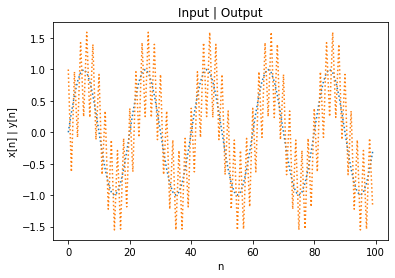

In [18]:
generate_report(output_dir, n, x, y)

In [20]:
write_csv_nxy(csv_filename, n, x, y)

In [21]:
# Using pandas for read csv file
dataframe = pd.read_csv(csv_filename)
dataframe

n         x         y
0      0  0.000000  1.000000
1      1  0.309017 -0.629180
2      2  0.587785  0.963702
3      3  0.809017 -0.080189
4      4  0.951057  1.426207
..   ...       ...       ...
995  995 -1.000000 -1.553667
996  996 -0.951057 -0.289714
997  997 -0.809017 -1.539839
998  998 -0.587785 -0.096796
999  999 -0.309017 -1.186716

[1000 rows x 3 columns]